# 3ML with Fermi GBM TTE  and LAT LLE Data
### Purpose

This demonstrates of you can use LLE data directly in 3ML

For more detail on the Fermi TTE plugin, check out its demo.

#### Let's check it out!

Import **3ML** as always to make sure you have the plugin.

In [1]:
%matplotlib inline
%matplotlib notebook
import numpy as np
from threeML import *

get_available_plugins()

Configuration read from /Users/jburgess/.threeML/threeML_config.yml
Available plugins:

DispersionSpectrumLike for General binned spectral data with energy dispersion
FermiGBMTTELike for Fermi GBM TTE (all detectors)
OGIPLike for All OGIP-compliant instruments
FermiLATLLELike for Fermi LAT LLE
FermipyLike for Fermi LAT (with fermipy)
XYLike for n.a.
EventListLike for Generic EventList data
HAWCLike for HAWC
SwiftXRTLike for Swift XRT
SpectrumLike for General binned spectral data


## Obtaining data

Use the LLE and GBM data downloaders to get the data:

In [2]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)
trigger_number = 'bn080916009'

data_dir_gbm = os.path.join('gbm',trigger_number)
gbm_data = download_GBM_trigger_data(trigger_number,detectors=['n3','n4','b0'],destination_directory=data_dir_gbm,compress_tte=True)


data_dir_lle = os.path.join('lat')

lle_data = download_LLE_trigger_data(trigger_number,destination_directory=data_dir_lle)

src_selection = "0.-71."

### Plugin building

Build our plugins from our data. The LLE plugin is an EventList like the GBM TTE plugin and operates in a similar way. 

Simply select a source interval, background interval(s), etc. (all of which can be changed later) and the plugin will prepare the data for you.

As with the TTE plugin (and any OGIPLike plugin), the data can be saved out to PHA files for cross-checking with XSPEC.

In [3]:
lle = FermiLATLLELike("LLE",
                      os.path.join(data_dir_lle, "gll_lle_bn080916009_v10.fit"),
                      os.path.join(data_dir_lle, "gll_pt_bn080916009_v10.fit"),
                      os.path.join(data_dir_lle, "gll_cspec_bn080916009_v10.rsp"),
                      src_selection,
                       "-100-0,100-200")



nai3 = FermiGBMTTELike('NAI3',
                       os.path.join(data_dir_gbm, "glg_tte_n3_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir_gbm, "glg_cspec_n3_bn080916009_v00.rsp2"),
                       src_selection,
                        "-10-0,120-200",
                       poly_order=2)

nai4 = FermiGBMTTELike('NAI4',
                       os.path.join(data_dir_gbm, "glg_tte_n4_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir_gbm, "glg_cspec_n4_bn080916009_v00.rsp2"),
                       src_selection,
                       "-10-0,120-200",
                       poly_order=-1,
                      verbose=False)

bgo0 = FermiGBMTTELike('BGO0',
                       os.path.join(data_dir_gbm, "glg_tte_b0_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir_gbm, "glg_cspec_b0_bn080916009_v00.rsp2"),
                        src_selection,
                       "-10-0,120-200")



Auto-determined polynomial order: 1




Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Binned 1-order polynomial fit with the Powell method


Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING UserWarning: No TLMIN keyword found. This DRM does not follow OGIP standards. Assuming TLMIN=1


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Unbinned 2-order polynomial fit with the Nelder-Mead method


Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"

WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum 

Auto-determined polynomial order: 1




Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Unbinned 1-order polynomial fit with the Nelder-Mead method


Auto-probed noise models:
- observation: poisson
- background: gaussian


#### What's in the plugin?


In [4]:
lle.display()

,0
n. channels,50
total rate,27.7296
total bkg. rate,6.00637
total bkg. rate error,0.187211
exposure,65.6699
bkg. exposure,65.6699
significance,42.9053
is poisson,True
bkg. is poisson,False
response,lat/gll_cspec_bn080916009_v10.rsp


Let's look at the lightcurve of LLE file to check out background fit:

<IPython.core.display.Javascript object>


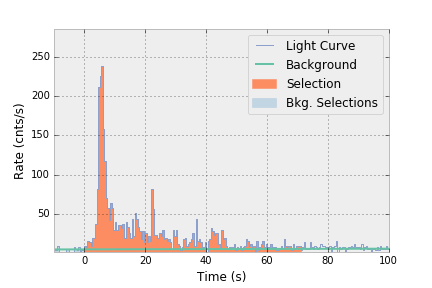

In [5]:
lle.view_lightcurve(-10,100,dt=.5)

And an NaI:

<IPython.core.display.Javascript object>


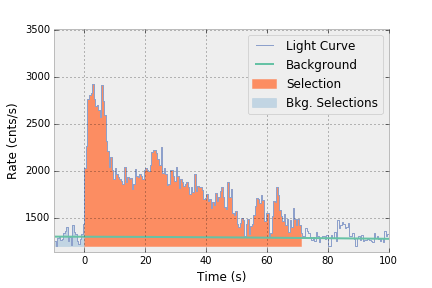

In [6]:
nai3.view_lightcurve(-10,100.,.5)

### Energy selection

Like any OGIPLike, we need to select the energies we would like to fit. LLE data below 50 MeV has a lot of dispersion and should not be selected as indicated by the BAD (red) region.

Range 50000-100000 translates to channels 11-16
Now using 6 channels out of 50


<IPython.core.display.Javascript object>


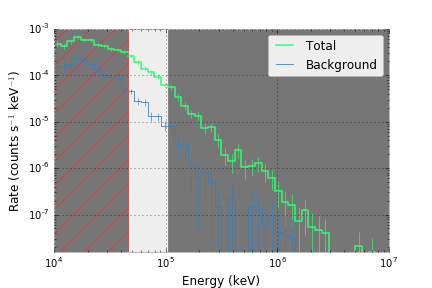

Range 10.0-30.0 translates to channels 6-21
Range 40.0-900.0 translates to channels 27-124
Now using 114 channels out of 128
Range 250-43000 translates to channels 1-126
Now using 126 channels out of 128


In [7]:

lle.set_active_measurements("50000-100000")
lle.view_count_spectrum()


nai3.set_active_measurements("10.0-30.0", "40.0-900.0")
nai4.set_active_measurements("10.0-30.0", "40.0-900.0")
bgo0.set_active_measurements("250-43000")


## Fitting!

We are now ready for the standard **3ML** process. We perform and MLE fit here, but Bayesian fitting is also possible.


In [8]:

ra = 121.8
dec = -61.3

data_list = DataList(nai3,nai4,bgo0,lle )

band= Band()

GRB = PointSource( trigger_number, ra, dec, spectral_shape=band )

model = Model( GRB )


In [9]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



,Value,Unit
bn080916009.spectrum.main.Band.K,(1.49 +/- 0.07) x 10^-2,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.06 +/- 0.04,
bn080916009.spectrum.main.Band.xp,(5.1 +/- 0.7) x 10^2,keV
bn080916009.spectrum.main.Band.beta,-2.173 +/- 0.024,



Correlation matrix:



1.00,0.91,-0.96,0.75
0.91,1.00,-0.88,0.66
-0.96,-0.88,1.00,-0.84
0.75,0.66,-0.84,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BGO0,1206.288860
LLE,29.612116
NAI3,1078.018262
NAI4,1040.378230
total,3354.297467


## Examining our fit

<IPython.core.display.Javascript object>


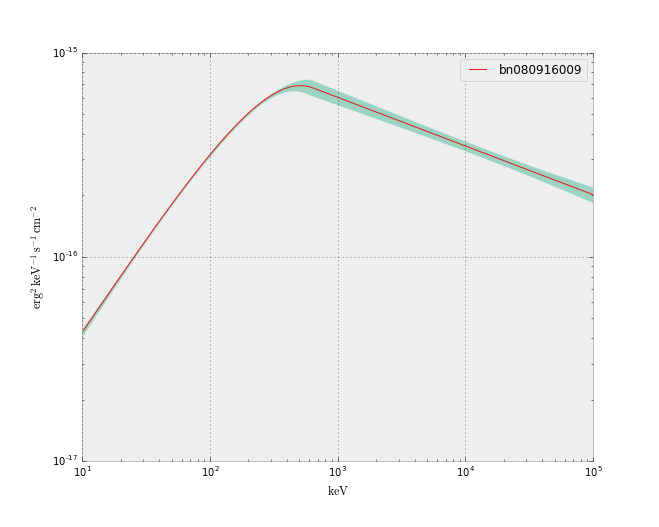

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [10]:
sp = SpectralPlotter(jl)

_=sp.plot_model(y_unit='erg2/(cm2 s keV)', num_ene=200,x_max=1E5)

We can examine our fit with the data:

<IPython.core.display.Javascript object>


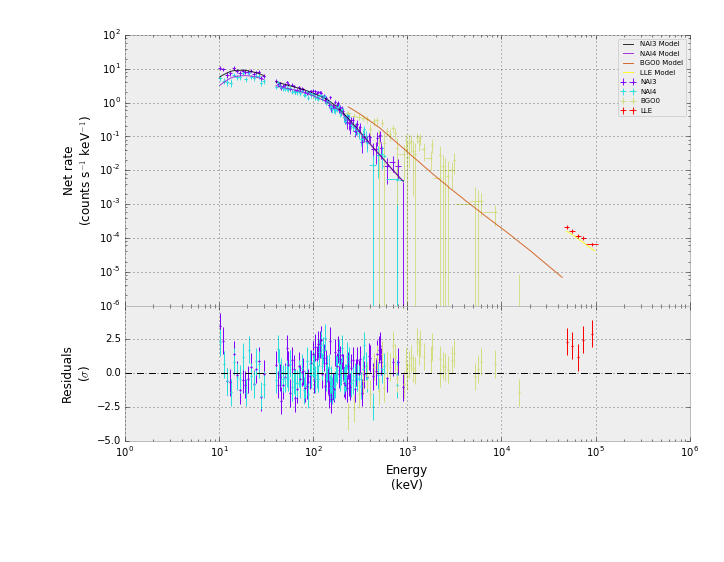

In [11]:
_ = display_ogip_model_counts(jl,min_rate=1,step=False)

In [12]:
res = jl.get_errors()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,(1.49 -0.07 +0.08) x 10^-2,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.06 +/- 0.04,
bn080916009.spectrum.main.Band.xp,(5.1 -0.6 +0.8) x 10^2,keV
bn080916009.spectrum.main.Band.beta,-2.173 -0.025 +0.022,


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<IPython.core.display.Javascript object>


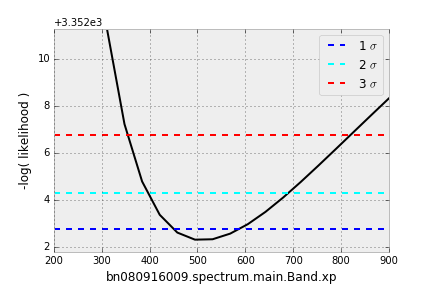

In [13]:
res = jl.get_contours(band.xp,200,900,20)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<IPython.core.display.Javascript object>


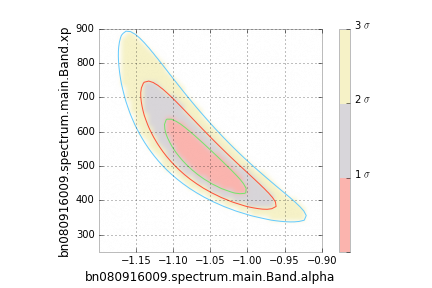

In [14]:
res = jl.get_contours(band.xp,250,900,50,band.alpha,-1.2,-0.9,50)